# Install neccessary libraries 

In [43]:
# !pip install contractions
# !pip install nltk
# !pip install autocorrect 
# !pip install --upgrade matplotlib

# Importing Neccessary Libraries and Dataset

In [82]:
# Word Processing
import string # from some string manipulation tasks
import nltk # natural language toolkit
import re # regex
import emoji
from string import punctuation # solving punctuation problems
from nltk.corpus import stopwords # stop words in sentences
from nltk.stem import WordNetLemmatizer, PorterStemmer # For stemming the sentence
from nltk.stem import SnowballStemmer # For stemming the sentence
from contractions import contractions_dict # to solve contractions
from autocorrect import Speller #correcting the spellings
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


# Libraries for general uses
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)  # No limit on columns
pd.set_option('display.max_rows', None)  

#Libraries for Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# WordCloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


#Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder


#Model
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier # Added XGBoost
from sklearn.linear_model import LogisticRegression # Added Logistic Regression
from sklearn.svm import SVC # Added Support Vector Machine (SVM)



[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jonat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jonat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jonat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
df = pd.read_csv('./Dataset/cyberbullying_tweets.csv')
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [46]:
df.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

In [47]:
df['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

In [48]:
df.drop(df[df['cyberbullying_type'] == 'other_cyberbullying'].index, inplace = True)
df['cyberbullying_type'].value_counts()

religion             7998
age                  7992
gender               7973
ethnicity            7961
not_cyberbullying    7945
Name: cyberbullying_type, dtype: int64

# Preprocessing

In [49]:
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})

In [50]:
df.sample(10)

,text,sentiment
34713,UC riverside is a bottom tier school,age
39898,Imagine this identical incident belonged to Tr...,ethnicity
37054,I completely understand first hand how people ...,age
3013,@truaemusic @mattybboi83 @Number10gov What are...,not_cyberbullying
42546,Fuck them niggers that killed those cops maybe...,ethnicity
44223,Can’t pick and choose when to respect police. ...,ethnicity
36931,It’s so funny seeing people/ teachers From my ...,age
44117,I looked it up and I don't know he had done an...,ethnicity
7736,"Popped a quick dinner in the oven, went and ha...",not_cyberbullying
3835,"@JimmyMcCunty @Spacekatgal oh, darn, you can't...",not_cyberbullying


In [51]:
df["sentiment"].replace({"religion": 1, "age": 2, "gender": 3, "ethnicity": 4, "not_cyberbullying": 5}, inplace=True)

In [52]:
sentiments = ["religion","age","gender","ethnicity","not bullying"]

Preprocessing Function

In [61]:
stop_words = set(stopwords.words('english'))

#Remove punctuations, links, stopwords, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    text =' '.join(word for word in text.split() if len(word) < 14) # remove words longer than 14 characters
    return text


def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text


#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the "#" symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

#Lemmatization 
def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])

def preprocess(text):
    text = decontract(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = stemmer(text)
    return text

In [62]:
texts_cleaned = []
for t in df.text:
    texts_cleaned.append(preprocess(t))


In [63]:
df['text_clean'] = texts_cleaned

In [65]:
df.sample(100)

,text,sentiment,text_clean
45571,come say that shit to a NIGGERS face? no? shut...,4,come say shit nigger face shut fuck dumbass fu...
2813,@brunoyudi33 pior que os outros bully passa lo...,5,pior que os outro bulli passa logo n 24 por um...
32645,i hate social media influencers man... it’s re...,2,hate social media influenc man realli grown me...
15244,ew that girl who keeps replying to Frankies tw...,3,ew girl keep repli franki tweet gay slur gross...
2865,RT @Jennaaayyy: Rob and Dave are definitely my...,5,rt rob dave definit favourit love relax posit ...
14288,But he really didn’t. MIB endorsing Biden is g...,3,realli didnt mib endors biden gay say he bad g...
11604,RT @FeministFailure: #QuestionsForMen Are you ...,3,rt awar femin teach women men can not experi s...
37605,Got bullied half of high school and managed to...,2,got bulli half high school manag pass class im...
5823,KAT AND ANDRE CANT COOK #MKR,5,kat andr cant cook mkr
44084,dis idiot tries 2 call me a nigger but ends up...,4,di idiot tri 2 call nigger end type nugget dum...


In [69]:
df["text_clean"].duplicated().sum()
df.drop_duplicates("text_clean", inplace=True)

In [70]:
df.sentiment.value_counts()

1    7946
2    7884
4    7746
5    7637
3    7607
Name: sentiment, dtype: int64

In [71]:
text_len = []
for text in df.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [72]:
df['text_len'] = text_len

In [73]:
df.head()

,text,sentiment,text_clean,text_len
0,"In other words #katandandre, your food was cra...",5,word katandandr food crapilici mkr,5
1,Why is #aussietv so white? #MKR #theblock #ImA...,5,aussietv white mkr theblock today sunris studi...,10
2,@XochitlSuckkks a classy whore? Or more red ve...,5,classi whore red velvet cupcak,5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",5,meh p thank head concern anoth angri dude twitter,9
4,@RudhoeEnglish This is an ISIS account pretend...,5,isi account pretend kurdish account like islam...,8


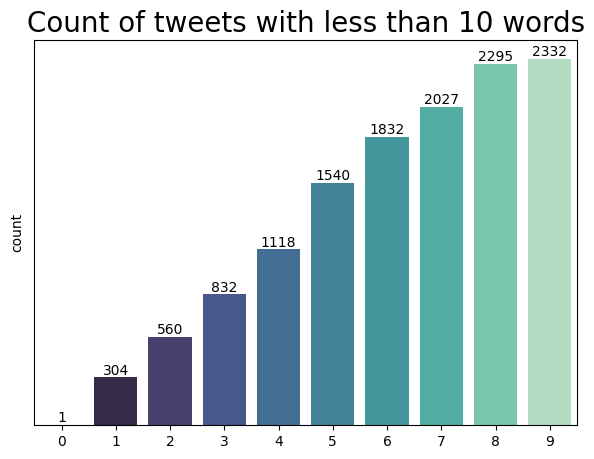

In [74]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [75]:
df = df.drop(df[df['text_len'] == 0].index)

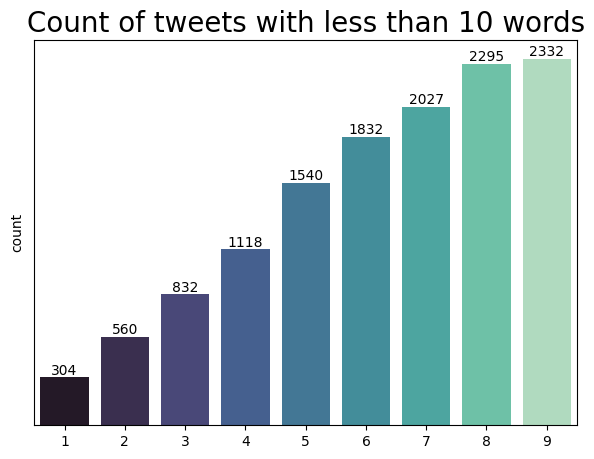

In [76]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [77]:
df = df[df['text_len'] < 100]

In [ ]:
lenc = LabelEncoder()
df.sentiment = lenc.fit_transform(df.sentiment)

for c in range(len(lenc.classes_)):
    string = ""
    for i in df[df.sentiment == c].text_clean.values:
        string = string + " " + i.strip()

    wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(string)
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(lenc.classes_[c])
    plt.show()
    del string

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 9)